In [ ]:
import numpy as np
import pandas as pd

salary_data = pd.read_csv('/content/all_salary_data.csv', encoding='latin1')
stats_data = pd.read_csv('/content/2010-2024_average(3).csv', encoding='latin1')
# 각 선수의 데이터를 추가할 열을 미리 정의
new_columns = ['Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
               'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

# 새로운 열을 미리 추가하고, 초기값은 None으로 설정
for col in new_columns:
    salary_data[col] = None

# 모든 행에 대해 데이터 처리
for idx, row in salary_data.iterrows():
    player_name = row['name']
    start_year = row['start']

    # start_year 이전 3년치 데이터 필터링
    filtered_stats = stats_data[(stats_data['name'] == player_name) &
                                (stats_data['year'].between(start_year-1, start_year))]

    if not filtered_stats.empty:
        # Pos 열 값 추가 (가장 위의 행에서 가져옴)
        salary_data.at[idx, 'Pos'] = filtered_stats.iloc[0]['Pos']
        filtered_stats.drop(columns=['Pos'], inplace=True, errors='ignore')

        # 나머지 열 값들 평균 계산 후 추가
        for col in new_columns[1:]:
            if col in filtered_stats.columns:
                salary_data.at[idx, col] = filtered_stats[col].astype(float).mean()
            else:
                salary_data.at[idx, col] = None
salary_data=salary_data.dropna()
# 업데이트된 데이터 저장
salary_data.to_csv('/content/final_nba_data(2).csv', index=False)

In [ ]:
cd ..

/


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('/content/final_nba_data.csv',encoding='ISO-8859-1')
data= data.dropna()
data.to_csv('/content/final_nba_data(2).csv', index=False)

Linear Regression - Mean Squared Error: 0.0013982828893474885, R^2 Score: 0.7500892646419991
Ridge Regression - Mean Squared Error: 0.0013822356525290567, R^2 Score: 0.7529573371789017
Lasso Regression - Mean Squared Error: 0.0023069139706455516, R^2 Score: 0.5876924682381611


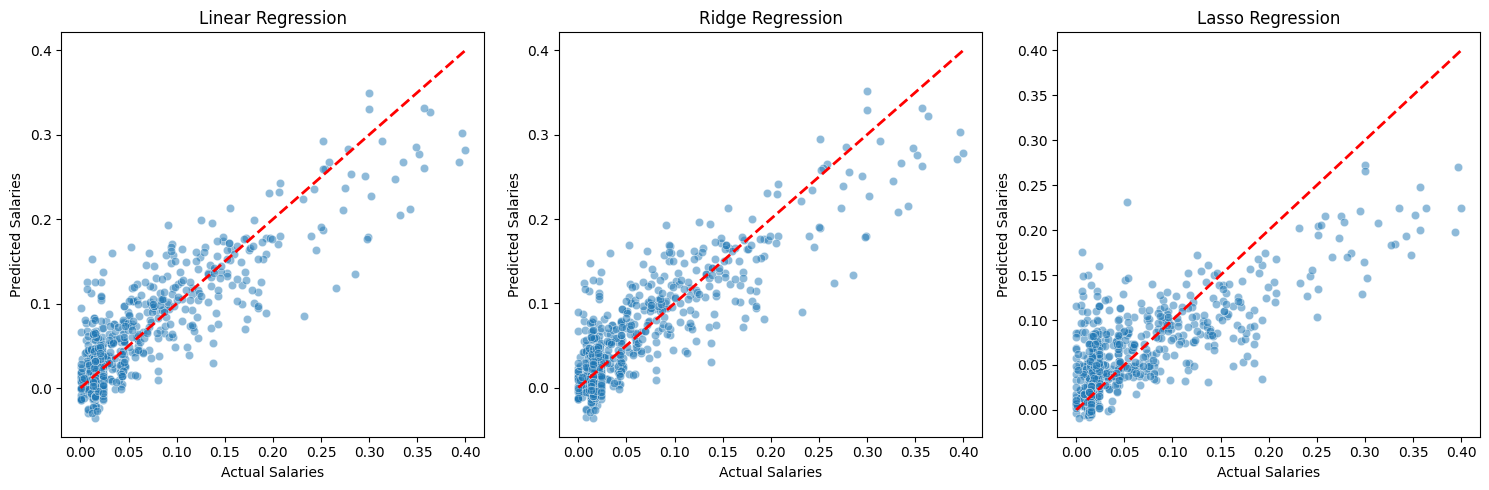

In [36]:


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/final_nba_data.csv')

# Display the first few rows of the dataset to check the data

# Define X and y
X = data.drop(['target','salary','debut','birth','name','Pos','G','ORB'],axis=1)
y = data['target']

X.head()


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Make predictions with Linear Regression
y_pred_linear = linear_model.predict(X_test_scaled)

# Initialize and train the Ridge regression model
ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X_train_scaled, y_train)

# Make predictions with Ridge Regression
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Initialize and train the Lasso regression model
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions with Lasso Regression
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Linear Regression - Mean Squared Error: {mse_linear}, R^2 Score: {r2_linear}')
print(f'Ridge Regression - Mean Squared Error: {mse_ridge}, R^2 Score: {r2_ridge}')
print(f'Lasso Regression - Mean Squared Error: {mse_lasso}, R^2 Score: {r2_lasso}')

# Visualize the results
plt.figure(figsize=(15, 5))

# Linear Regression Plot
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Linear Regression')

# Ridge Regression Plot
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Ridge Regression')

# Lasso Regression Plot
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Lasso Regression')

plt.tight_layout()
plt.show()

In [22]:
X.head()
X.dtypes

start       int64
end         int64
G         float64
GS        float64
MP        float64
FG        float64
FGA       float64
FG%       float64
3P        float64
3PA       float64
3P%       float64
2P        float64
2PA       float64
2P%       float64
eFG%      float64
FT        float64
FTA       float64
FT%       float64
ORB       float64
DRB       float64
TRB       float64
AST       float64
STL       float64
BLK       float64
TOV       float64
PF        float64
PTS       float64
age         int64
Pos_C     float64
Pos_PF    float64
Pos_PG    float64
Pos_SF    float64
Pos_SG    float64
dtype: object

<ipython-input-35-b57e39f4d0ad>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_correlations, y=best_features, palette='viridis')


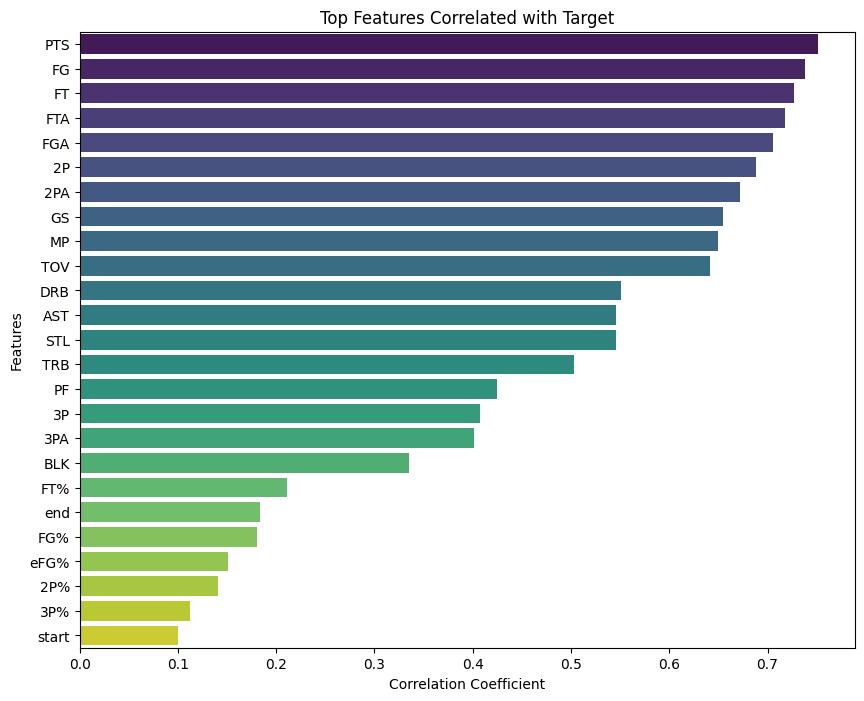

Top 25 Features R2 Score: 0.7499182707399463
Linear Regression - Mean Squared Error: 0.0014237440564110351, R^2 Score: 0.7499182707399481
Ridge Regression - Mean Squared Error: 0.0014178344131190014, R^2 Score: 0.7509563040909053
Lasso Regression - Mean Squared Error: 0.002392511352815615, R^2 Score: 0.5797535563416609


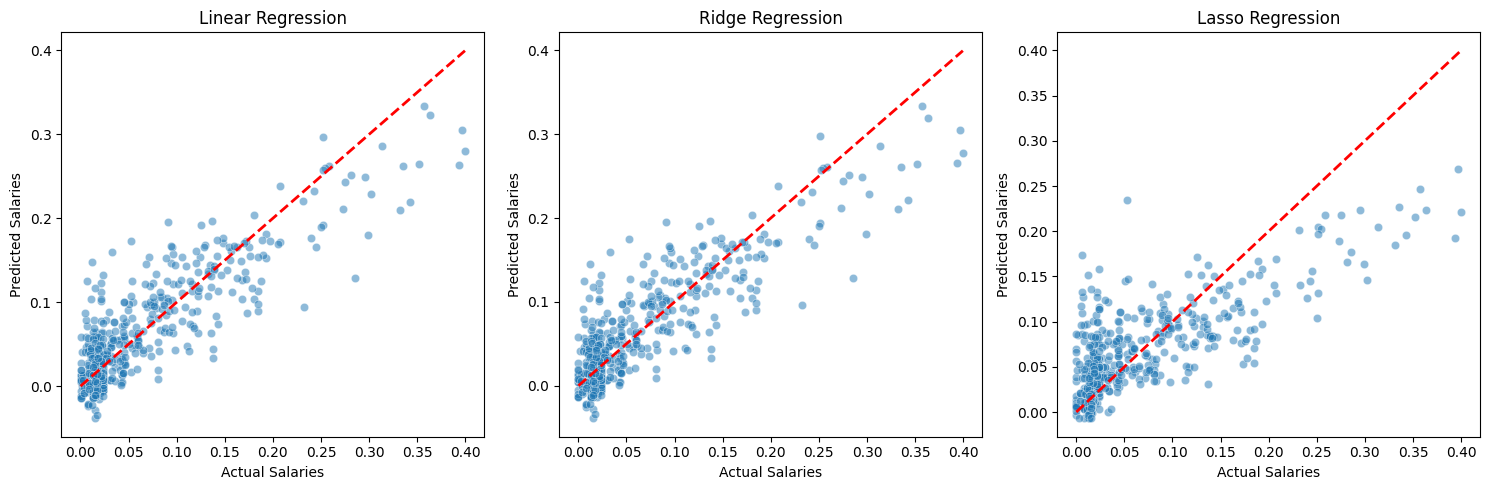

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/final_nba_data.csv')

# Display the first few rows of the dataset to check the data

# Define X and y
X = data.drop(['target','salary','debut','birth','name','Pos','G','ORB'],axis=1)
y = data['target']

# Combine X and y for correlation calculation
df = X.copy()
df['target'] = y

# Calculate correlation matrix
correlation_matrix = df.corr()
target_correlations = correlation_matrix['target'].drop('target')
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

best_r2_score = 0
best_N = 0
best_features = None
target_length = len(target_correlations.tolist()) + 1

# Model to use for evaluation
best_model = LinearRegression()

for N in range(1, target_length):
    top_N_features = sorted_correlations.head(N).index
    top_N_feature_data = X[top_N_features]
    train_X, test_X, train_y, test_y = train_test_split(top_N_feature_data, y, test_size=0.3, random_state=42)

    best_model.fit(train_X, train_y)
    test_predictions = best_model.predict(test_X)

    r2 = r2_score(test_y, test_predictions)
    if r2 > best_r2_score:
        best_r2_score = r2
        best_N = N
        best_features = top_N_features

# best_features에 해당하는 상위 N개의 상관계수 값을 가져옵니다.
top_correlations = sorted_correlations[best_features]

plt.figure(figsize=(10, 8))
sns.barplot(x=top_correlations, y=best_features, palette='viridis')
plt.title('Top Features Correlated with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

print(f"Top {best_N} Features R2 Score: {best_r2_score}")

# Split the data into training and testing sets with the best features
X_train, X_test, y_train, y_test = train_test_split(X[best_features], y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Make predictions with Linear Regression
y_pred_linear = linear_model.predict(X_test_scaled)

# Initialize and train the Ridge regression model
ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X_train_scaled, y_train)

# Make predictions with Ridge Regression
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Initialize and train the Lasso regression model
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions with Lasso Regression
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Linear Regression - Mean Squared Error: {mse_linear}, R^2 Score: {r2_linear}')
print(f'Ridge Regression - Mean Squared Error: {mse_ridge}, R^2 Score: {r2_ridge}')
print(f'Lasso Regression - Mean Squared Error: {mse_lasso}, R^2 Score: {r2_lasso}')

# Visualize the results
plt.figure(figsize=(15, 5))

# Linear Regression Plot
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Linear Regression')

# Ridge Regression Plot
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Ridge Regression')

# Lasso Regression Plot
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Lasso Regression')

plt.tight_layout()
plt.show()
